# **EDA, Feature Engineering, Hypothesis Testing, and Classification on NFT Collection Dataset**

### **Introduction**

##### What is Niftyprices?
Niftyprice is a new and small team focused on providing the most up to date and comprehensive NFT data in the market today. As you know, this is a fast moving space, so we are working hard to continually push updates, increase our coverage, and enhance our data engine to provide you the best product possible while staying up to speed on all the rapid changes taking place in the NFT world. At the end of the day, we're here for you, the NFT investors and patrons, so please let us know any feedback you have or how we can help solve your burning NFT issues. -NP [(source)](https://www.niftyprice.io/about)

##### What are NFT's?
A non-fungible token is a unit of data stored on a digital ledger, called a blockchain, that certifies a digital asset to be unique and therefore not interchangeable. NFTs can be used to represent items such as photos, videos, audio, and other types of digital files. [(source)](https://www.niftyprice.io/about)

### **Dataset Overview**

##### Feature Information

* Collection Name: The name of the NFT collection.
* Floor Purchase Price: The lowest price of any NFT in the collection in Ethereum (ETH).
* 24%: The percentage of floor price's moving values per 24 hours.
* 7d%: The percentage of floor price's moving values per 7 days.
* Total Float: The toral amount of minted NFTs.
* Floor Cap: The lowest market capitalization—total value of the collection's items in circulation—in in Ethereum (ETH).
* Volume: The volume of sales from the NFT collection in Ethereum (ETH) per 24 hours.
* 24h Volume%: The percentage of volume's moving values per 24 hours.
* Sales: The number of sales from the NFT collection.
* 24h Owners%: The ownership percentage of all items in the collection per 24 hours.
* %Float: The percentage of listed NFTs.
* 24h supply%: The percentage of supply's moving values per 24 hours.
* image_url: The associated image of the NFT collection.

##### Source

Dataset was scraped from [niftyprices](https://www.kaggle.com/fedesoriano/heart-failure-prediction) on February 20, 2022.
You can scrape the latest data by yourself using ['scraper.py'](https://github.com/berodimas/one-month-one-dataset/blob/master/%5B2022-02%5D%20NFT%20Price%20Analysis%20and%20Regression/data/scraper.py) python script on 'data' folder.


### **Section 1: Setup, Load, and Clean** 

In [1]:
import os
data_path = ['data']

In [2]:
## Import neccessary libraries to load data
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Load in the Dataset
filepath = os.sep.join(
    data_path + ['2022-03-01_niftyprice.csv'])
df = pd.read_csv(filepath)
df = df.sort_values(by=['Floor Cap'], ascending=False, ignore_index=True)

In [4]:
df.head()

,Collection Name,Floor Purchase Price,24h%,7d%,Total Float,Floor Cap,Volume,24h Volume%,Sales,24h Owners%,%Float,24h supply%,image_url
0,boredapeyachtclub,88.888,2.18,-2.85,10000,888880.0,619,0.004870,7,0.05,6.06,3.06,https://lh3.googleusercontent.com/Ju9CkWtV-1Ok...
1,cryptopunks,68.000,0.00,1.64,9999,679932.0,826,-0.694752,11,0.00,13.54,0.30,https://lh3.googleusercontent.com/BdxvLseXcfl5...
2,wolf-game,36.000,0.00,0.00,10443,375948.0,0,NaN,0,0.00,0.01,0.00,https://lh3.googleusercontent.com/MMwQ4ukXLIqz...
3,mutant-ape-yacht-club,17.800,-3.21,-2.73,16403,291973.4,384,-0.020408,19,0.03,6.21,-0.29,https://lh3.googleusercontent.com/lHexKRMpw-ao...
4,clonex,13.250,3.52,-1.85,16710,221407.5,298,-0.305361,20,0.08,8.08,2.90,https://lh3.googleusercontent.com/XN0XuD8Uh3jy...


In [5]:
## Examine the information from the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Collection Name       609 non-null    object 
 1   Floor Purchase Price  609 non-null    float64
 2   24h%                  609 non-null    float64
 3   7d%                   609 non-null    float64
 4   Total Float           609 non-null    int64  
 5   Floor Cap             609 non-null    float64
 6   Volume                609 non-null    int64  
 7   24h Volume%           428 non-null    float64
 8   Sales                 609 non-null    int64  
 9   24h Owners%           609 non-null    float64
 10  %Float                609 non-null    float64
 11  24h supply%           609 non-null    float64
 12  image_url             580 non-null    object 
dtypes: float64(8), int64(3), object(2)
memory usage: 62.0+ KB


In [6]:
## If there's no volume change in past 7 days it might be newly listed
## Therfore we gonna remove rows with 0 value on '7d%' column
df = df[df['7d%'] != 0]

In [7]:
## Fill NaN value to 0
df['24h Volume%'].fillna(value=0, inplace=True)

In [8]:
## We plan to choose top 200 NFT's collections
df = df.drop(df.index[200:])

In [9]:
df= df.reset_index(drop=True)

In [10]:
## Drop all unnecessary columns
df.drop(columns=['image_url', '24h supply%', '7d%',
        'Floor Cap', 'Collection Name'], inplace=True)


In [11]:
## Take a quick look of the dataframe
df

,Floor Purchase Price,24h%,Total Float,Volume,24h Volume%,Sales,24h Owners%,%Float
0,88.8880,2.18,10000,619,0.004870,7,0.05,6.06
1,68.0000,0.00,9999,826,-0.694752,11,0.00,13.54
2,17.8000,-3.21,16403,384,-0.020408,19,0.03,6.21
3,13.2500,3.52,16710,298,-0.305361,20,0.08,8.08
4,24.8000,-0.40,7558,0,0.000000,0,-0.18,0.17
...,...,...,...,...,...,...,...,...
195,0.4500,-10.00,5073,3,-0.400000,4,0.04,7.45
196,0.4968,-14.34,4469,18,-0.672727,32,-0.15,7.03
197,0.2200,-9.47,10010,3,-0.250000,12,-0.28,5.97
198,0.2785,-2.28,7790,4,-0.200000,15,-0.86,4.63


In [12]:
## Re-examine the information from the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Floor Purchase Price  200 non-null    float64
 1   24h%                  200 non-null    float64
 2   Total Float           200 non-null    int64  
 3   Volume                200 non-null    int64  
 4   24h Volume%           200 non-null    float64
 5   Sales                 200 non-null    int64  
 6   24h Owners%           200 non-null    float64
 7   %Float                200 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 12.6 KB


In [13]:
## Create range section in describe table
nft_df = df.copy()
stat_df = nft_df.describe()
stat_df.loc['range'] = stat_df.loc['max'] - stat_df.loc['min']
stat_df.T

,count,mean,std,min,25%,50%,75%,max,range
Floor Purchase Price,200.0,6.815387,28.279739,0.10,0.474500,1.0695,2.602500,299.00,298.90
24h%,200.0,-1.999250,14.490176,-34.02,-7.987500,-2.7350,0.000000,153.06,187.08
Total Float,200.0,8221.940000,4737.843085,35.00,5036.250000,9043.0000,10005.000000,28561.00,28526.00
Volume,200.0,64.965000,164.997073,0.00,7.000000,18.0000,48.250000,1718.00,1718.00
24h Volume%,200.0,0.299050,1.818345,-1.00,-0.376488,0.0000,0.430195,22.00,23.00
Sales,200.0,36.775000,67.912776,0.00,5.750000,14.5000,35.000000,494.00,494.00
24h Owners%,200.0,-0.099700,1.387376,-15.02,-0.150000,0.0000,0.042500,7.41,22.43
%Float,200.0,5.555300,4.994214,0.17,2.770000,4.4200,6.527500,34.76,34.59


In [14]:
## Import neccessary libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="dark")

<AxesSubplot:>

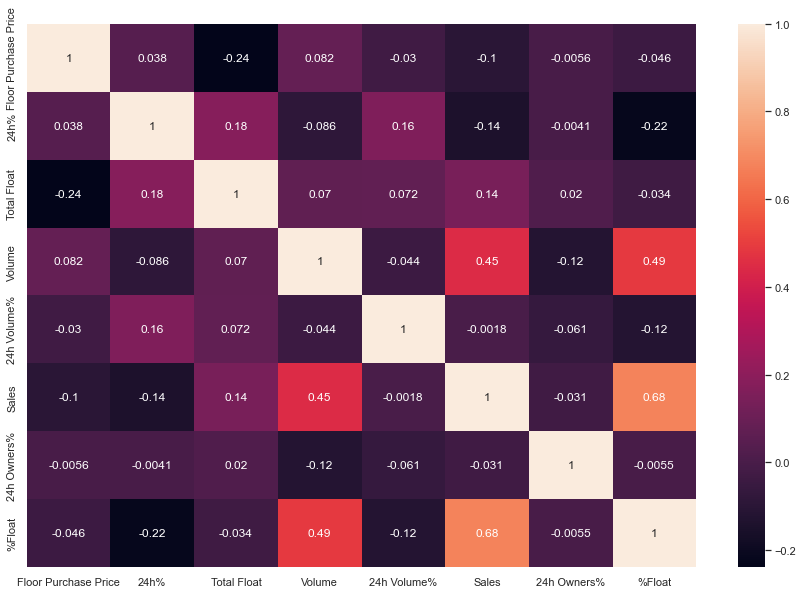

In [15]:
plt.figure(figsize=[15, 10])
sns.heatmap(data=nft_df.corr(), annot=True)


In [16]:
## There are 3 potential column to be our target variable
## We gonna choose column with highest correlation with each others

corr_column_target = ['Volume', 'Sales', '%Float']
headers = ['Column Name', 'Sum of Correlations']
df_corr_result = pd.DataFrame(columns=headers)
i = 0

for k in corr_column_target:
    fields = list(nft_df.columns)
    fields.remove(k)
    y = (nft_df[k])
    correlations = nft_df[fields].corrwith(y)
    df_corr_result.loc[i] = [k, correlations.abs().sum()]
    i += 1

df_corr_result.sort_values(
    by=['Sum of Correlations'], ascending=False, ignore_index=True)


,Column Name,Sum of Correlations
0,%Float,1.599193
1,Sales,1.543980
2,Volume,1.341167


First Section Short Recap/Conclusion:
* '%Float' have the highest correlation with each other.
* We gonna compare each column as a target for Regression session. 

### **Section 2: Simple Exploratory Data Analysis (EDA)**

In [17]:
## Check for unique variables on each features
## Making sure that all of the columns were numerical

nft_df.nunique()

Floor Purchase Price    176
24h%                    171
Total Float             161
Volume                   82
24h Volume%             144
Sales                    73
24h Owners%              82
%Float                  185
dtype: int64

In [18]:
numerical_data_columns = list(nft_df.columns)

#### **Numerical Data Columns EDA**

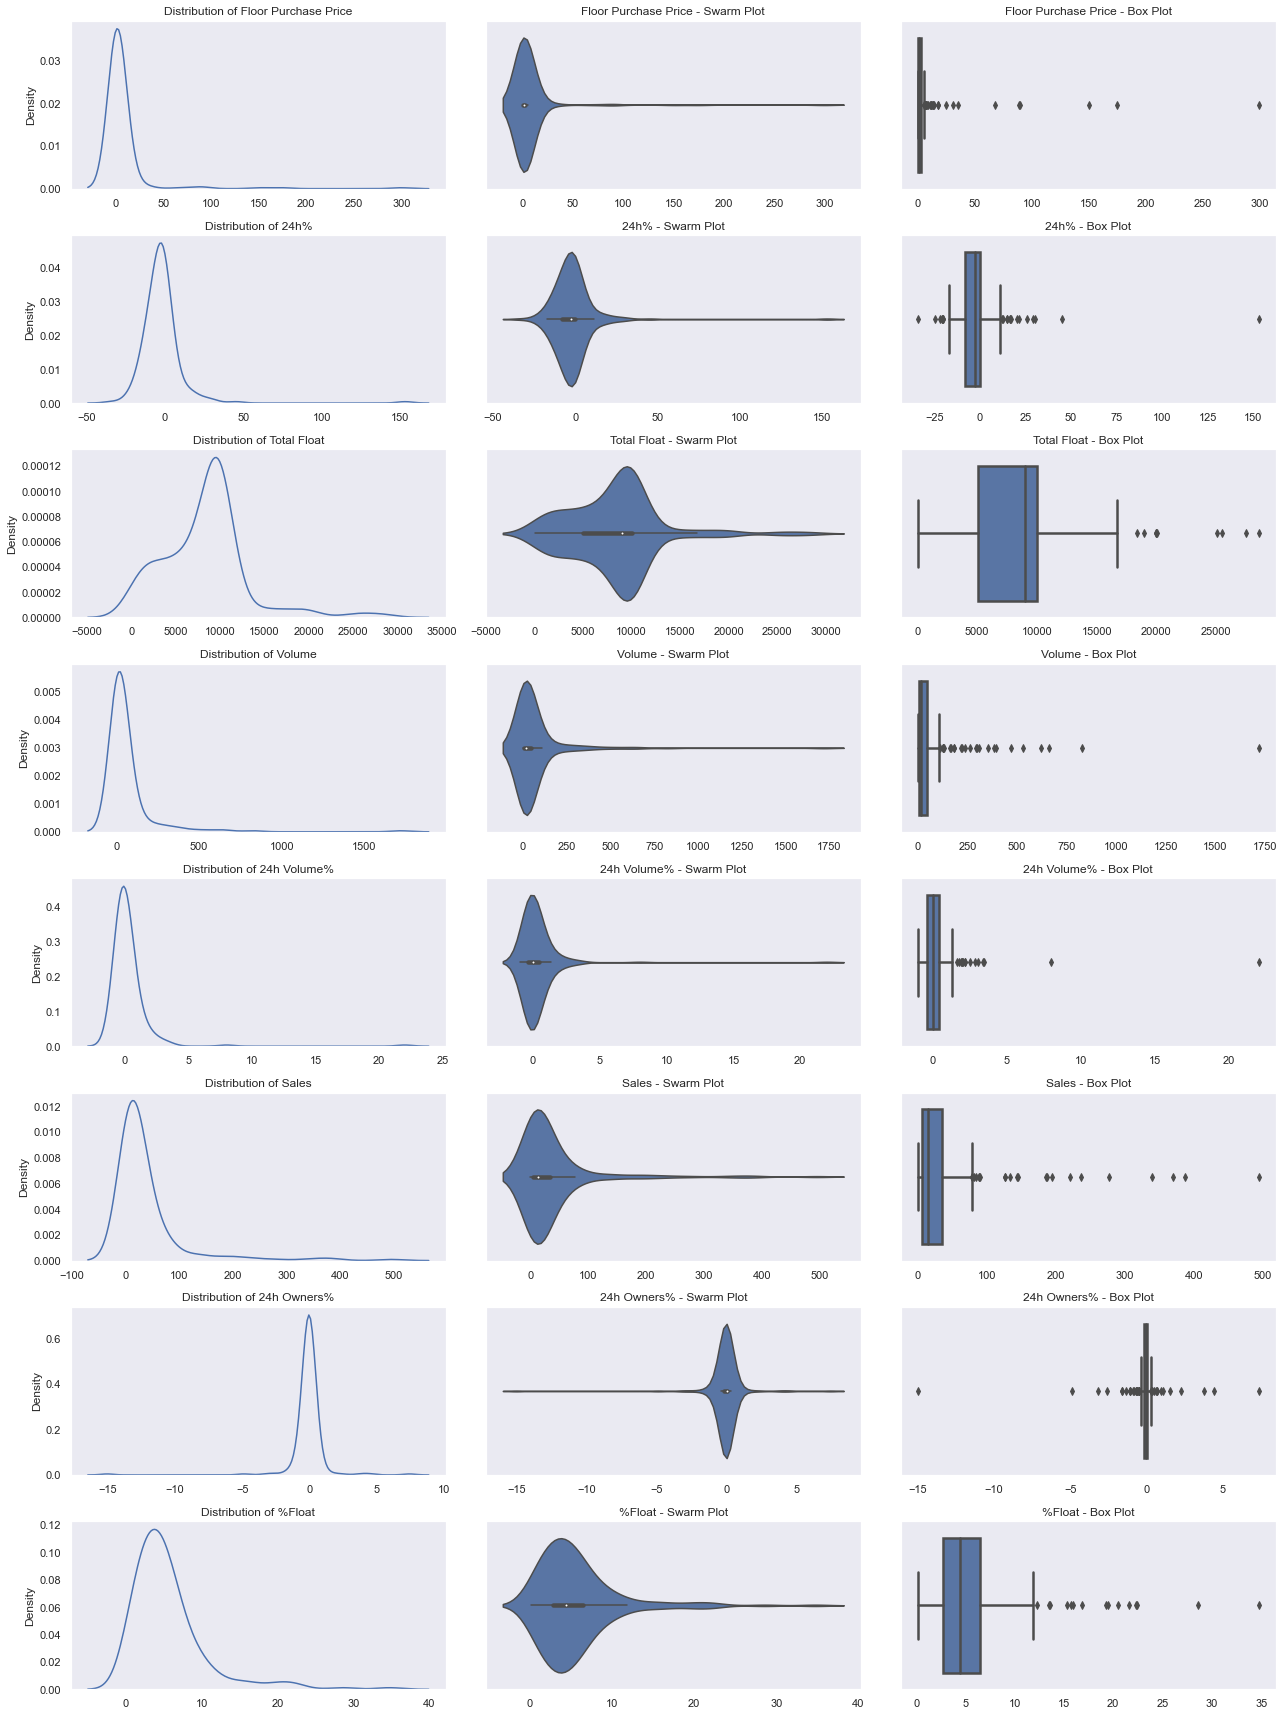

In [19]:
## Visualize distribution on numerical features
rows = len(numerical_data_columns)
cols = 3

fig = plt.figure(1, (18, rows*3))

i = 0
for feature in numerical_data_columns:

    i += 1
    ax1 = plt.subplot(rows, cols, i)
    sns.kdeplot(data=nft_df, x=feature)
    ax1.set_xlabel(None)
    ax1.set_title(f'Distribution of {feature}')
    plt.tight_layout()

    i += 1
    ax2 = plt.subplot(rows, cols, i)
    sns.violinplot(data=nft_df, x=feature)
    ax2.set_xlabel(None)
    ax2.set_title(f'{feature} - Swarm Plot')
    plt.tight_layout()

    i += 1
    ax3 = plt.subplot(rows, cols, i)
    sns.boxplot(data=nft_df, x=feature, orient='h', linewidth=2.5)
    ax3.set_xlabel(None)
    ax3.set_title(f'{feature} - Box Plot')
    plt.tight_layout()

plt.show()


In [20]:
## Find outliers using Tukey's method
def tukey_outliers(x):
    ## Tukey outliers are based on the boundaries defined by quantiles and IQR
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)

    iqr = q3 - q1

    lower_boundary = q1 - (iqr * 1.5)
    upper_boundary = q3 + (iqr * 1.5)

    outliers = x[(x < lower_boundary) | (x > upper_boundary)]
    return outliers


In [21]:
## Calculate the tukey outliers
outlier_dict = {}
for num_feature in numerical_data_columns:
    outliers = tukey_outliers(nft_df[num_feature])
    if len(outliers):
        print(f"-> {num_feature} has {len(outliers)} tukey outliers")
        outlier_dict[num_feature] = outliers
    else:
        print(f"-> {num_feature} doesn't have any tukey outliers.")
        outlier_dict[num_feature] = None


-> Floor Purchase Price has 26 tukey outliers
-> 24h% has 21 tukey outliers
-> Total Float has 9 tukey outliers
-> Volume has 25 tukey outliers
-> 24h Volume% has 15 tukey outliers
-> Sales has 22 tukey outliers
-> 24h Owners% has 34 tukey outliers
-> %Float has 15 tukey outliers


In [22]:
## Show the percentage of outliers

for x in numerical_data_columns:
    outliers = nft_df.loc[outlier_dict[x].index]
    print("{} has {}% of outliers".format(
        x, round(len(outliers)/len(nft_df) * 100, 2)))


Floor Purchase Price has 13.0% of outliers
24h% has 10.5% of outliers
Total Float has 4.5% of outliers
Volume has 12.5% of outliers
24h Volume% has 7.5% of outliers
Sales has 11.0% of outliers
24h Owners% has 17.0% of outliers
%Float has 7.5% of outliers


In [23]:
## Perform test whether a sample differs from a normal distribution
from scipy.stats import normaltest

ALPHA = 0.05

for col in nft_df:
    stat, p = normaltest(nft_df[col].values)
    print('{}: stat={}, p={}'.format(col, stat, p))
    if p <= ALPHA:
        print('Probably not Gaussian\n')
    else:
        print('Probably Gaussian\n')


Floor Purchase Price: stat=316.07195614607167, p=2.321917478231033e-69
Probably not Gaussian

24h%: stat=291.31790311159415, p=5.509613060927256e-64
Probably not Gaussian

Total Float: stat=54.298023333540655, p=1.61932508648859e-12
Probably not Gaussian

Volume: stat=284.7421228745872, p=1.4758208276623873e-62
Probably not Gaussian

24h Volume%: stat=354.26211772159263, p=1.182928684697652e-77
Probably not Gaussian

Sales: stat=194.42056191809934, p=6.0549616277049535e-43
Probably not Gaussian

24h Owners%: stat=271.33532249822673, p=1.2030490840542885e-59
Probably not Gaussian

%Float: stat=129.43076004327602, p=7.842735389163618e-29
Probably not Gaussian



Numerical Data Columns EDA Short Recap/Conclusion:
* '24h Owners% ' has the highest percentage of outliers with '17%'.
* All of the columns were probably not normally distributed.
* We gonna analyze skewness on next section.

### **Section 3: Feature Engineering**

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [25]:
## Create list of scaler

scalers = [
    (MinMaxScaler(), "MinMaxScaler"),
    (StandardScaler(), "StandardScaler")
]


In [26]:
## Compare result of skewness after scaled from each scaler
for scaler, scaler_desc in scalers:
    nft_df_fe = nft_df.copy()
    skew_result = []
    for column in numerical_data_columns:
        nft_df_fe[[column]] = scaler.fit_transform(nft_df_fe[[column]])
        skew_result.append({column: nft_df_fe[column].skew()})
    print("Skew Result After " + scaler_desc)
    print(skew_result)
    print("----------")


Skew Result After MinMaxScaler
[{'Floor Purchase Price': 7.622971987823639}, {'24h%': 6.445260418708285}, {'Total Float': 1.151688867075795}, {'Volume': 6.38053339982749}, {'24h Volume%': 9.110121232395436}, {'Sales': 3.961280903326318}, {'24h Owners%': -5.483347390827999}, {'%Float': 2.550361678976997}]
----------
Skew Result After StandardScaler
[{'Floor Purchase Price': 7.622971987823639}, {'24h%': 6.445260418708285}, {'Total Float': 1.151688867075795}, {'Volume': 6.3805333998274865}, {'24h Volume%': 9.110121232395436}, {'Sales': 3.961280903326317}, {'24h Owners%': -5.483347390828004}, {'%Float': 2.5503616789769974}]
----------


In [27]:
## Both were pretty same, so use any of those wouldn't be much problem
nft_df_fe = nft_df.copy()
for column in [numerical_data_columns]:
    nft_df_fe[column] = StandardScaler().fit_transform(nft_df_fe[column])


In [28]:
## Display statistical value after scaling
nft_df_fe.describe().T

,count,mean,std,min,25%,50%,75%,max
Floor Purchase Price,200.0,0.000000e+00,1.002509,-0.238059,-0.224783,-0.203690,-0.149346,10.357869
24h%,200.0,0.000000e+00,1.002509,-2.215370,-0.414300,-0.050903,0.138319,10.727845
Total Float,200.0,-1.065814e-16,1.002509,-1.732325,-0.674080,0.173733,0.377289,4.303667
Volume,200.0,-1.776357e-17,1.002509,-0.394722,-0.352191,-0.285356,-0.101559,10.043712
24h Volume%,200.0,1.776357e-17,1.002509,-0.716206,-0.372445,-0.164876,0.072304,11.964403
Sales,200.0,1.776357e-17,1.002509,-0.542862,-0.457982,-0.328817,-0.026202,6.749428
24h Owners%,200.0,4.440892e-18,1.002509,-10.781321,-0.036346,0.072043,0.102753,5.426465
%Float,200.0,1.776357e-17,1.002509,-1.081014,-0.559105,-0.227893,0.195154,5.862381


In [29]:
## Take a quick look of the dataframe
nft_df_fe


,Floor Purchase Price,24h%,Total Float,Volume,24h Volume%,Sales,24h Owners%,%Float
0,2.909453,0.289143,0.376231,3.366274,-0.162190,-0.439530,0.108172,0.101311
1,2.168979,0.138319,0.376019,4.623990,-0.547914,-0.380483,0.072043,1.602802
2,0.389402,-0.083766,1.731081,1.938432,-0.176127,-0.262390,0.093720,0.131421
3,0.228105,0.381852,1.796041,1.415903,-0.333231,-0.247628,0.129850,0.506794
4,0.637550,0.110645,-0.140487,-0.394722,-0.164876,-0.542862,-0.058024,-1.081014
...,...,...,...,...,...,...,...,...
195,-0.225651,-0.553536,-0.666304,-0.376495,-0.385408,-0.483815,0.100946,0.380331
196,-0.223992,-0.853800,-0.794108,-0.285356,-0.535771,-0.070487,-0.036346,0.296023
197,-0.233805,-0.516867,0.378347,-0.376495,-0.302708,-0.365722,-0.130284,0.083244
198,-0.231731,-0.019424,-0.091397,-0.370419,-0.275142,-0.321436,-0.549388,-0.185739


In [30]:
skew_limit = 0.75
df_skew = nft_df_fe.copy()
skew_vals = df_skew.skew()

In [31]:
## Display skewness value for each columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0: 'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols


,Skew
24h Volume%,9.110121
Floor Purchase Price,7.622972
24h%,6.445260
Volume,6.380533
Sales,3.961281
%Float,2.550362
Total Float,1.151689
24h Owners%,-5.483347


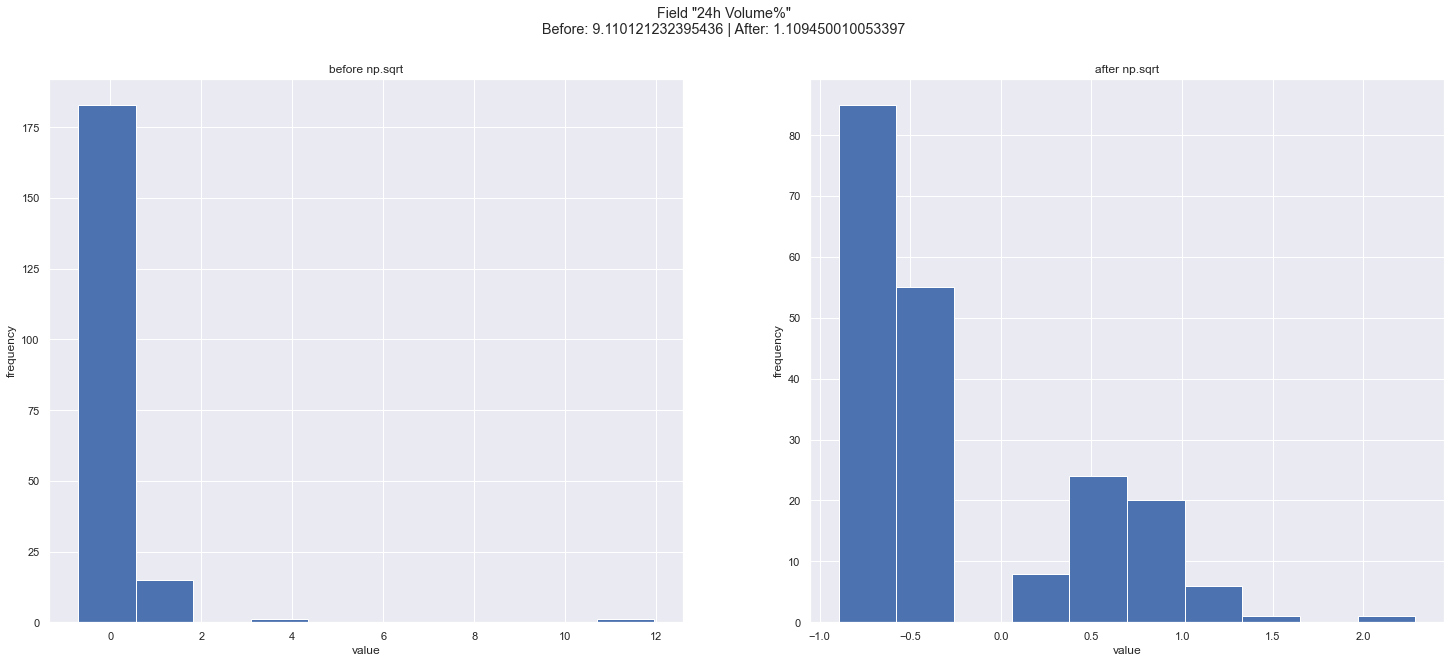

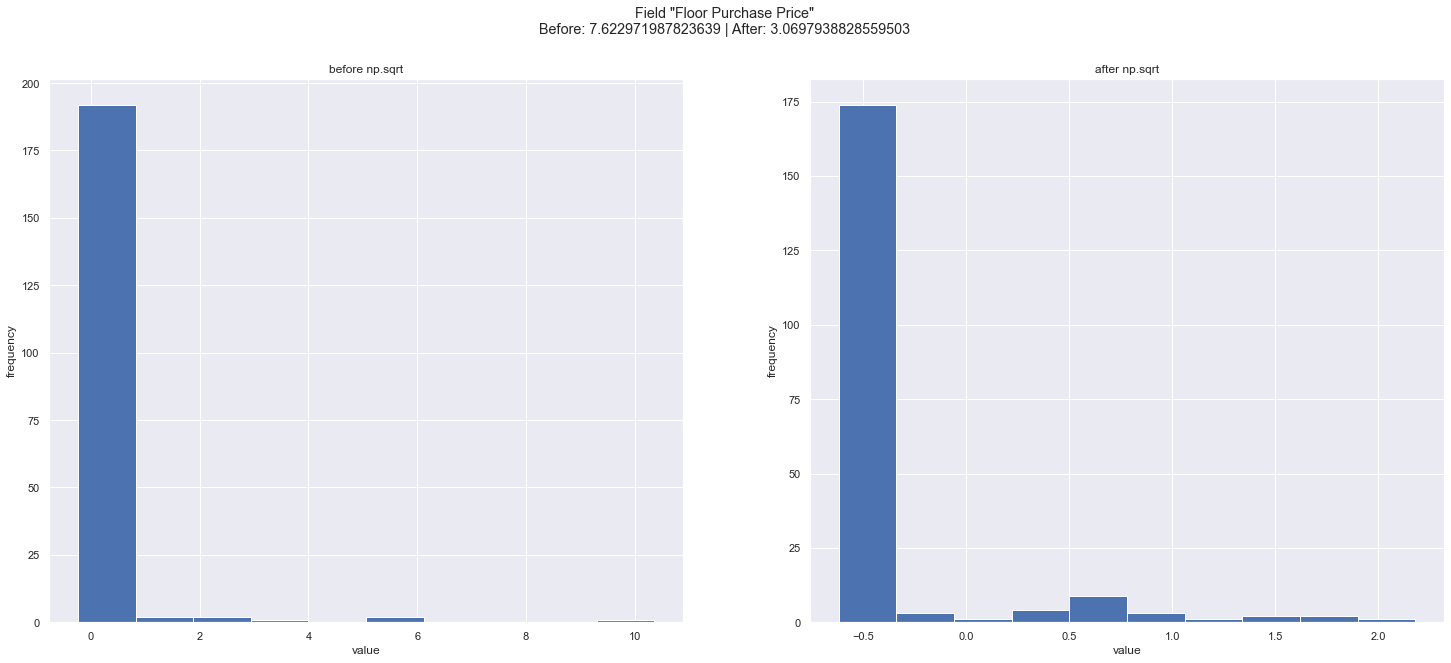

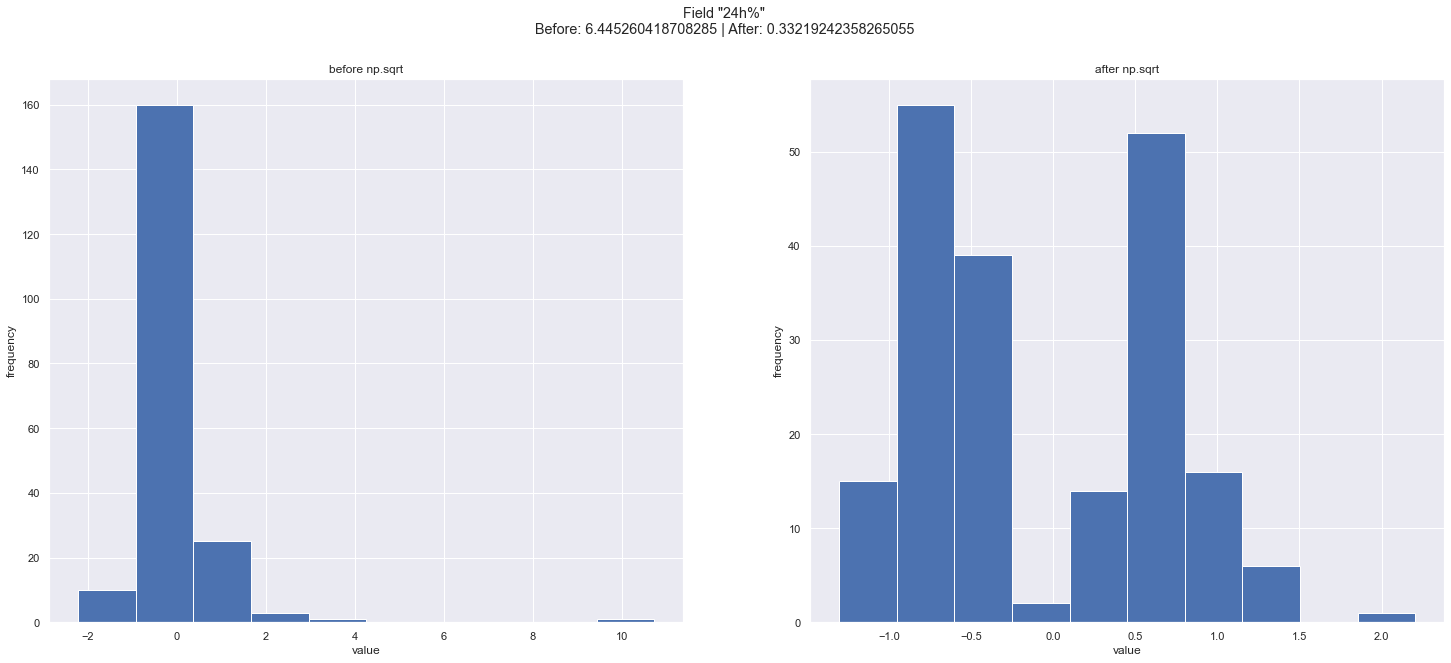

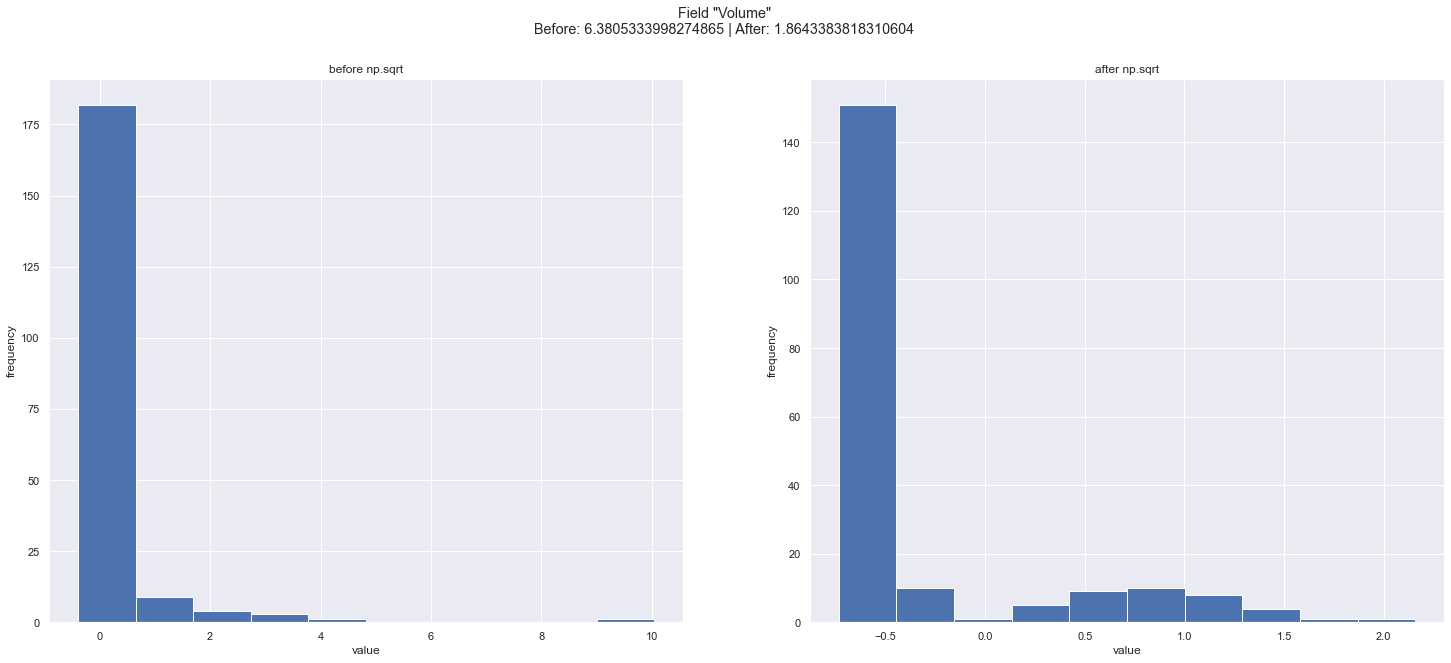

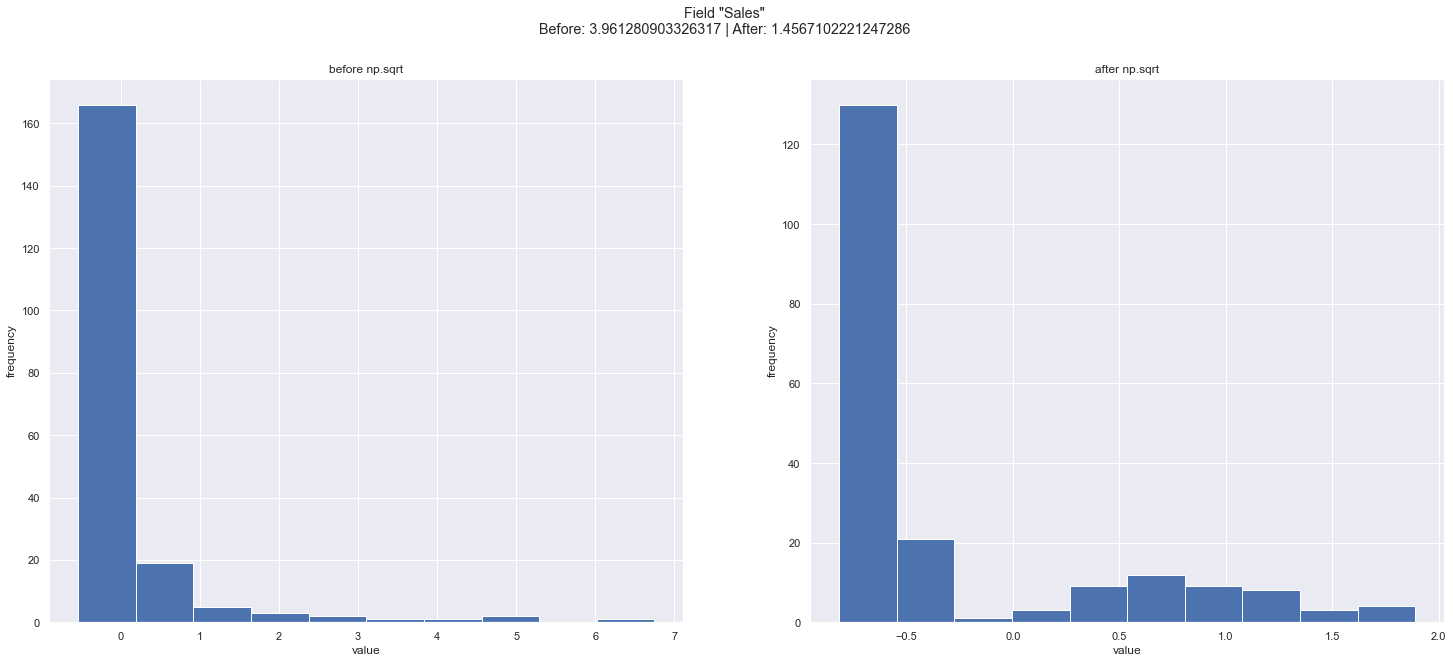

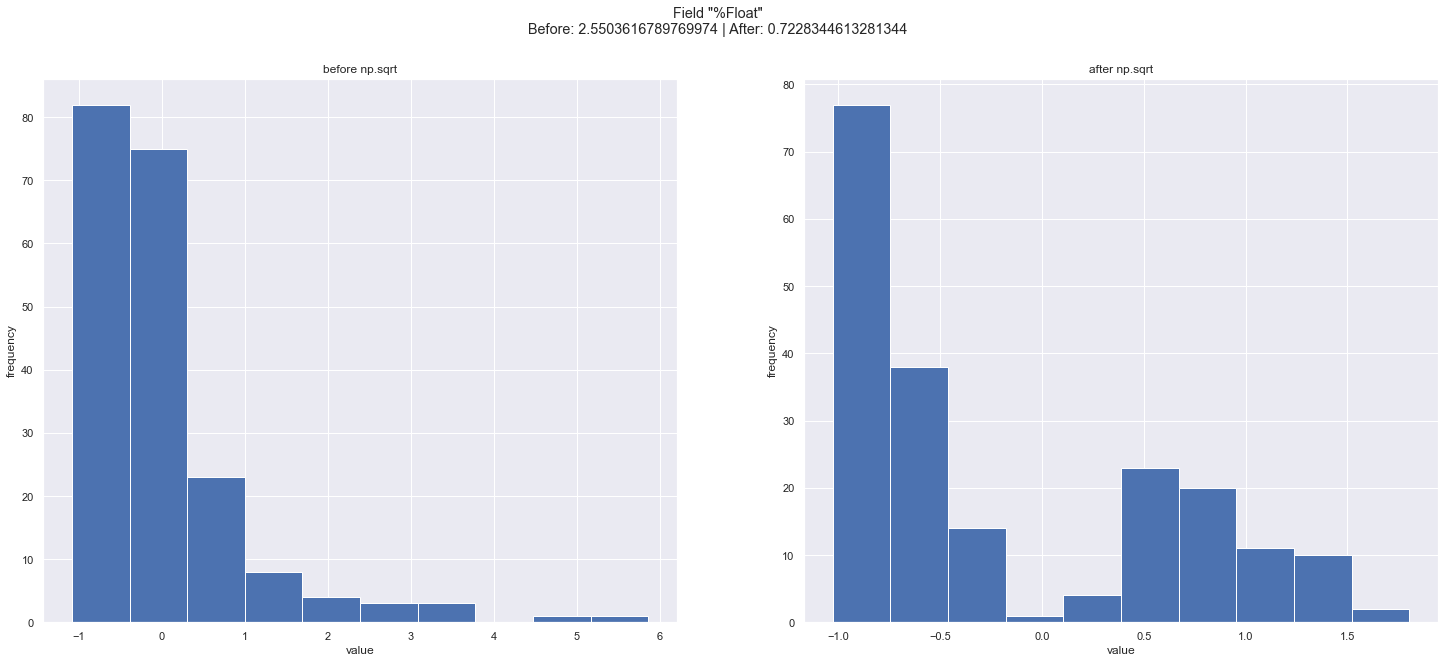

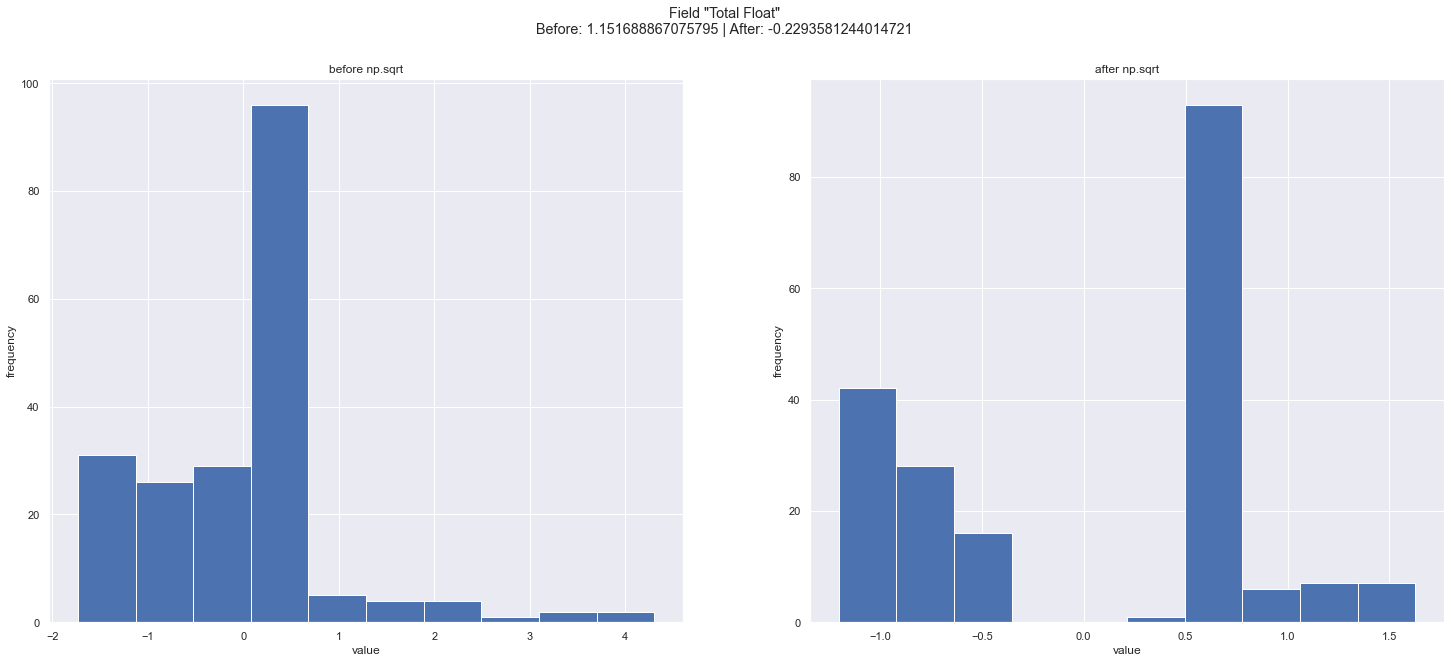

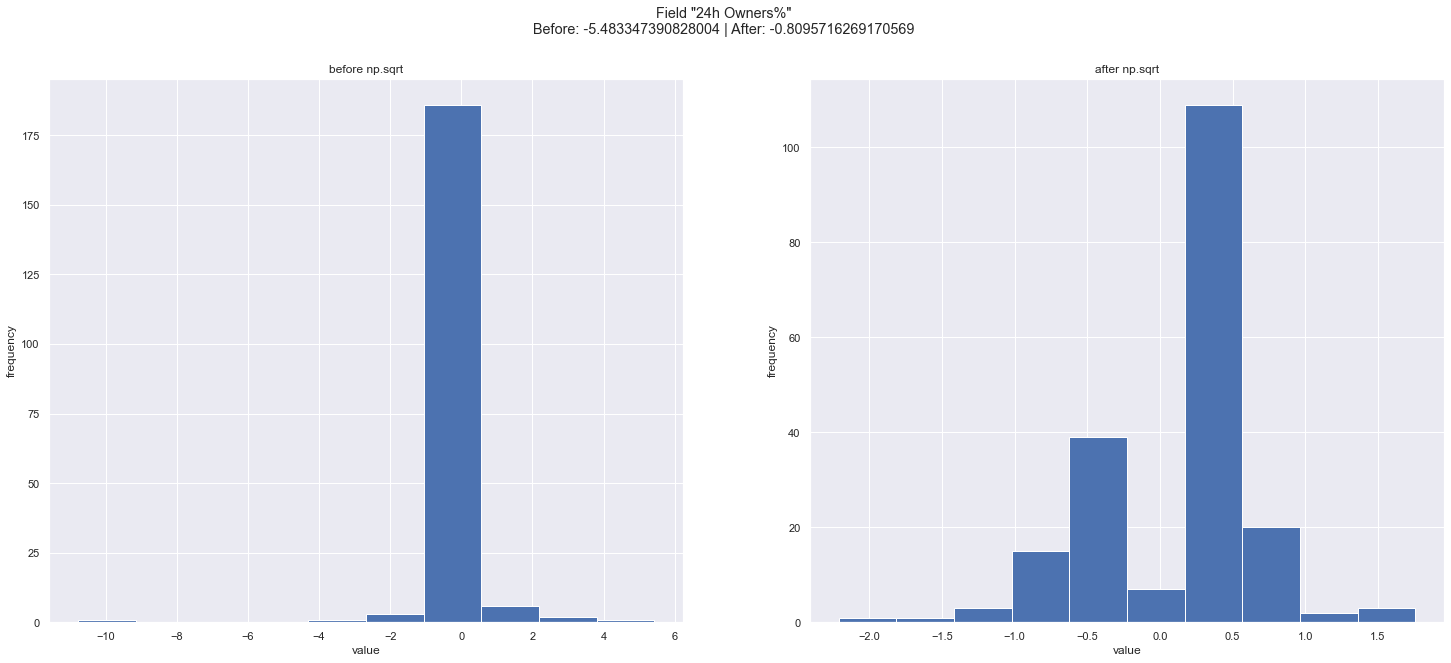

In [32]:
## Create before-after tansformation graph
skew_features = skew_cols.index.tolist()
for field in skew_features:
    # Create two "subplots" and a "figure" using matplotlib
    fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(25, 10))

    # Create a histogram on the "ax_before" subplot
    df_skew[field].hist(ax=ax_before)

    # after_skew = np.sqrt(df_skew[field] + 0 - min(df_skew[field]))
    after_skew = np.cbrt(df_skew[field])

    # Apply a log transformation (numpy syntax) to this column
    after_skew.hist(ax=ax_after)

    # Formatting of titles etc. for each subplot
    ax_before.set(title='before np.sqrt', ylabel='frequency', xlabel='value')
    ax_after.set(title='after np.sqrt', ylabel='frequency', xlabel='value')
    fig.suptitle('Field "{}"\nBefore: {} | After: {}\n'.format(
        field, df_skew[field].skew(), after_skew.skew()))


In [33]:
## Apply transformation to the feature
for column in numerical_data_columns:
    df_skew[column] = np.cbrt(df_skew[column])


In [34]:
df_skew

,Floor Purchase Price,24h%,Total Float,Volume,24h Volume%,Sales,24h Owners%,%Float
0,1.427591,0.661258,0.721913,1.498706,-0.545350,-0.760320,0.476473,0.466178
1,1.294449,0.517163,0.721777,1.665990,-0.818284,-0.724623,0.416099,1.170289
2,0.730241,-0.437545,1.200713,1.246858,-0.560543,-0.640200,0.454232,0.508418
3,0.611006,0.725490,1.215548,1.122909,-0.693290,-0.627962,0.506385,0.797279
4,0.860673,0.480076,-0.519851,-0.733551,-0.548343,-0.815762,-0.387142,-1.026306
...,...,...,...,...,...,...,...,...
195,-0.608807,-0.821073,-0.873422,-0.722082,-0.727735,-0.785043,0.465619,0.724526
196,-0.607311,-0.948678,-0.926033,-0.658358,-0.812194,-0.413082,-0.331249,0.666461
197,-0.616053,-0.802527,0.723264,-0.722082,-0.671441,-0.715128,-0.506948,0.436635
198,-0.614226,-0.268810,-0.450447,-0.718176,-0.650407,-0.685012,-0.819017,-0.570560


Feature Transformation Short Recap/Conclusion:
* Because there's negative value on skewed features ('Oldpeak'), we gonna use Cube Root as Feature Transformation approach. 
* After Feature Transformation with Cube Root method, all of the skewness seems getting close to 0.75.

### **Section 4: Regression**

In [35]:
df_skew.head()

,Floor Purchase Price,24h%,Total Float,Volume,24h Volume%,Sales,24h Owners%,%Float
0,1.427591,0.661258,0.721913,1.498706,-0.545350,-0.760320,0.476473,0.466178
1,1.294449,0.517163,0.721777,1.665990,-0.818284,-0.724623,0.416099,1.170289
2,0.730241,-0.437545,1.200713,1.246858,-0.560543,-0.640200,0.454232,0.508418
3,0.611006,0.725490,1.215548,1.122909,-0.693290,-0.627962,0.506385,0.797279
4,0.860673,0.480076,-0.519851,-0.733551,-0.548343,-0.815762,-0.387142,-1.026306


In [36]:
## Split the Training and Test set with KFold
## We gonna make 3 type of Training and Test set: %Float, Sales, and Volume

from sklearn.model_selection import KFold

X_float = df_skew.drop(columns=["%Float"])
y_float = df_skew["%Float"]

X_sales = df_skew.drop(columns=["Sales"])
y_sales = df_skew["Sales"]

X_volume = df_skew.drop(columns=["Volume"])
y_volume = df_skew["Volume"]

kf = KFold(shuffle=True, random_state=72018, n_splits=4)


In [37]:
## Import neccessary libraries for modelling

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

import datetime


In [38]:
## Create list of transformers

transformers = [
    (PolynomialFeatures(degree=1), "PolynomialFeatures (Degree 1)"),
    (PolynomialFeatures(degree=2), "PolynomialFeatures (Degree 2)"),
    (PolynomialFeatures(degree=3), "PolynomialFeatures (Degree 3)")
]


In [39]:
## Create list of models

models = [
    Lasso(max_iter=1000),
    Ridge(max_iter=1000)
]


In [40]:
search_space_dict = {}

search_space_dict['Lasso'] = {
    'lasso__alpha': np.geomspace(0.001, 0.1, 50)
}

search_space_dict['Ridge'] = {
    'ridge__alpha': np.geomspace(0.001, 0.1, 50)
}



In [41]:
## Create pipeline matrix

pipelines_matrix = {}

for transformer, transformer_desc in transformers:
    pipelines_matrix[transformer_desc] = {}
    print(transformer_desc)
    for model in models:
        print("            ", model.__class__.__name__)
        pipelines_matrix[transformer_desc][model.__class__.__name__] = make_pipeline(
            transformer, model)


PolynomialFeatures (Degree 1)
             Lasso
             Ridge
PolynomialFeatures (Degree 2)
             Lasso
             Ridge
PolynomialFeatures (Degree 3)
             Lasso
             Ridge


In [42]:
## Create a function for performing cross validation of all algorithms
## Fuction will return a dataframe with the result from each pipeline

def cross_validator(X_train, y_train, pipelines_matrix):
    i = 0
    for transformer in pipelines_matrix:
        print("----------------------", transformer)
        for model in pipelines_matrix[transformer]:
            i += 1
            print("     +++++++", model)
            startT = datetime.datetime.now()

            pipeline = pipelines_matrix[transformer][model]

            search_space = search_space_dict[model]
            regressor = GridSearchCV(pipeline,
                                search_space,
                                scoring='neg_root_mean_squared_error',
                                cv=kf)
            regressor.fit(X_train, y_train)

            print("          rmse: ", regressor.best_score_)

            headers = ['transformer', 'model',
                       'rmse', 'best_params']
            dfResultsTemp = pd.DataFrame(columns=headers)
            dfResultsTemp.loc[0] = [
                transformer, model, regressor.best_score_, regressor.best_params_]

            print("             exec time:", datetime.datetime.now() -
                  startT, datetime.datetime.now())

            if i == 1:
                data_concat = dfResultsTemp.copy()
            else:
                data_concat = pd.concat([data_concat, dfResultsTemp])

    return data_concat


#### **GridSearch with '%Float' as Target**

In [43]:
grid_search_df = cross_validator(X_float, y_float, pipelines_matrix)


---------------------- PolynomialFeatures (Degree 1)
     +++++++ Lasso
          rmse:  -0.7023030330440436
             exec time: 0:00:00.303032 2022-03-06 18:28:59.436655
     +++++++ Ridge
          rmse:  -0.7039029939697747
             exec time: 0:00:00.309004 2022-03-06 18:28:59.745768
---------------------- PolynomialFeatures (Degree 2)
     +++++++ Lasso
          rmse:  -0.6909864058967283
             exec time: 0:00:00.355671 2022-03-06 18:29:00.101750
     +++++++ Ridge
          rmse:  -0.7992305748273109
             exec time: 0:00:00.285979 2022-03-06 18:29:00.387929
---------------------- PolynomialFeatures (Degree 3)
     +++++++ Lasso
          rmse:  -0.6886822647833499
             exec time: 0:00:01.687022 2022-03-06 18:29:02.075167
     +++++++ Ridge
          rmse:  -1.3486868925270277
             exec time: 0:00:02.077496 2022-03-06 18:29:04.152941


In [44]:
grid_search_df.sort_values(by=['rmse'], ascending=False, ignore_index=True)

,transformer,model,rmse,best_params
0,PolynomialFeatures (Degree 3),Lasso,-0.688682,{'lasso__alpha': 0.01151395399326447}
1,PolynomialFeatures (Degree 2),Lasso,-0.690986,{'lasso__alpha': 0.022229964825261943}
2,PolynomialFeatures (Degree 1),Lasso,-0.702303,{'lasso__alpha': 0.013894954943731374}
3,PolynomialFeatures (Degree 1),Ridge,-0.703903,{'ridge__alpha': 0.1}
4,PolynomialFeatures (Degree 2),Ridge,-0.799231,{'ridge__alpha': 0.1}
5,PolynomialFeatures (Degree 3),Ridge,-1.348687,{'ridge__alpha': 0.1}


In [45]:
pipeline = Pipeline(steps=[
    ('transformer', PolynomialFeatures(degree=3)),
    ('model', Lasso(alpha=0.01151395399326447, max_iter=1000))])


In [46]:
pipeline.fit(X_float, y_float)


Pipeline(steps=[('transformer', PolynomialFeatures(degree=3)),
                ('model', Lasso(alpha=0.01151395399326447))])

In [47]:
y_predict = pipeline.predict(X_float)
print(
    f"RMSE Score for Lasso Regression: {mean_squared_error(y_float, y_predict, squared=False)}")
print(f"R2 Score for Lasso Regression: {r2_score(y_float, y_predict)}")


RMSE Score for Lasso Regression: 0.559347815073145
R2 Score for Lasso Regression: 0.5153900992431406


[Text(0.5, 0, 'Actual Confidence'),
 Text(0, 0.5, 'Predicted Confidence'),
 (0.0, 1.8031202068813825),
 (0.0, 1.8031202068813825),
 Text(0.5, 1.0, 'Lasso Regression Results')]

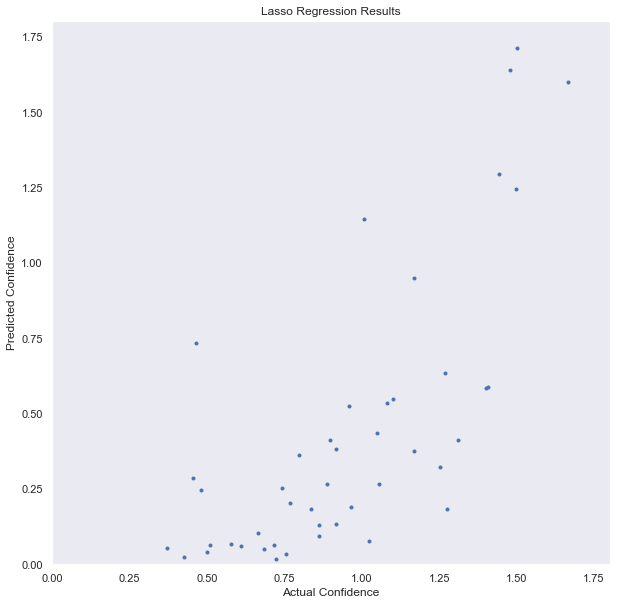

In [48]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes()

ax.plot(y_float, pipeline.predict(X_float),
        marker='o', ls='', ms=3.0)

lim = (0, y_float.max())

ax.set(xlabel='Actual Confidence',
       ylabel='Predicted Confidence',
       xlim=lim,
       ylim=lim,
       title='Lasso Regression Results')


#### **GridSearch with 'Sales' as Target**

In [49]:
grid_search_df = cross_validator(X_sales, y_sales, pipelines_matrix)


---------------------- PolynomialFeatures (Degree 1)
     +++++++ Lasso
          rmse:  -0.5025950022194425
             exec time: 0:00:00.307158 2022-03-06 18:29:04.889167
     +++++++ Ridge
          rmse:  -0.5032805392463919
             exec time: 0:00:00.275632 2022-03-06 18:29:05.164897
---------------------- PolynomialFeatures (Degree 2)
     +++++++ Lasso
          rmse:  -0.4574792458012503
             exec time: 0:00:00.326954 2022-03-06 18:29:05.492076
     +++++++ Ridge
          rmse:  -0.5340761238077107
             exec time: 0:00:00.286723 2022-03-06 18:29:05.778996
---------------------- PolynomialFeatures (Degree 3)
     +++++++ Lasso
          rmse:  -0.455916357434325
             exec time: 0:00:01.306788 2022-03-06 18:29:07.085995
     +++++++ Ridge
          rmse:  -0.8766472571548076
             exec time: 0:00:02.172026 2022-03-06 18:29:09.258235


In [50]:
grid_search_df.sort_values(by=['rmse'], ascending=False, ignore_index=True)

,transformer,model,rmse,best_params
0,PolynomialFeatures (Degree 3),Lasso,-0.455916,{'lasso__alpha': 0.016768329368110076}
1,PolynomialFeatures (Degree 2),Lasso,-0.457479,{'lasso__alpha': 0.020235896477251564}
2,PolynomialFeatures (Degree 1),Lasso,-0.502595,{'lasso__alpha': 0.0071968567300115215}
3,PolynomialFeatures (Degree 1),Ridge,-0.503281,{'ridge__alpha': 0.1}
4,PolynomialFeatures (Degree 2),Ridge,-0.534076,{'ridge__alpha': 0.1}
5,PolynomialFeatures (Degree 3),Ridge,-0.876647,{'ridge__alpha': 0.1}


In [51]:
pipeline = Pipeline(steps=[
    ('transformer', PolynomialFeatures(degree=3)),
    ('model', Lasso(alpha=0.016768329368110076, max_iter=1000))])


In [52]:
pipeline.fit(X_sales, y_sales)


Pipeline(steps=[('transformer', PolynomialFeatures(degree=3)),
                ('model', Lasso(alpha=0.016768329368110076))])

In [53]:
y_predict = pipeline.predict(X_sales)
print(
    f"RMSE Score for Lasso Regression: {mean_squared_error(y_sales, y_predict, squared=False)}")
print(f"R2 Score for Lasso Regression: {r2_score(y_sales, y_predict)}")


RMSE Score for Lasso Regression: 0.39144298699421104
R2 Score for Lasso Regression: 0.6916537936266001


[Text(0.5, 0, 'Actual Confidence'),
 Text(0, 0.5, 'Predicted Confidence'),
 (0.0, 1.8898281586702523),
 (0.0, 1.8898281586702523),
 Text(0.5, 1.0, 'Lasso Regression Results')]

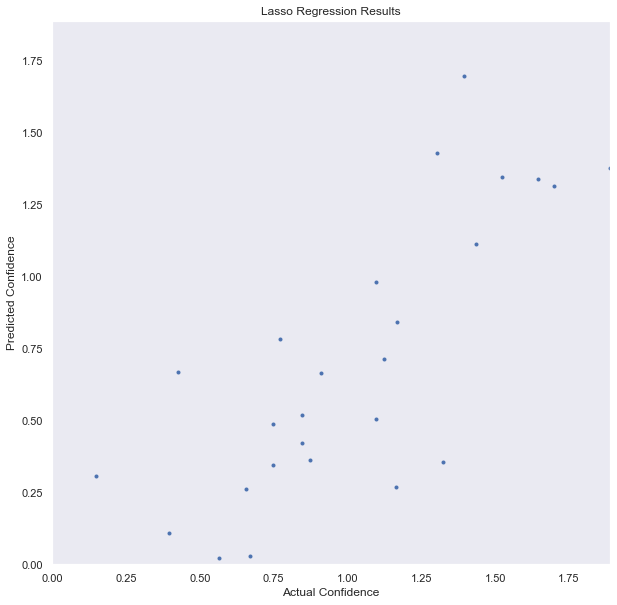

In [54]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes()

ax.plot(y_sales, pipeline.predict(X_sales),
        marker='o', ls='', ms=3.0)

lim = (0, y_sales.max())

ax.set(xlabel='Actual Confidence',
       ylabel='Predicted Confidence',
       xlim=lim,
       ylim=lim,
       title='Lasso Regression Results')


#### **GridSearch with 'Volume' as Target**

In [55]:
grid_search_df = cross_validator(X_volume, y_volume, pipelines_matrix)


---------------------- PolynomialFeatures (Degree 1)
     +++++++ Lasso
          rmse:  -0.47588573662546624
             exec time: 0:00:00.361092 2022-03-06 18:29:09.995066
     +++++++ Ridge
          rmse:  -0.47654348250383266
             exec time: 0:00:00.286000 2022-03-06 18:29:10.281330
---------------------- PolynomialFeatures (Degree 2)
     +++++++ Lasso
          rmse:  -0.3917764273713985
             exec time: 0:00:00.413556 2022-03-06 18:29:10.695109
     +++++++ Ridge
          rmse:  -0.48756782363718315
             exec time: 0:00:00.298661 2022-03-06 18:29:10.993981
---------------------- PolynomialFeatures (Degree 3)
     +++++++ Lasso
          rmse:  -0.3407160459127194
             exec time: 0:00:01.164386 2022-03-06 18:29:12.158582
     +++++++ Ridge
          rmse:  -0.7271183882052439
             exec time: 0:00:01.802065 2022-03-06 18:29:13.960858


In [56]:
grid_search_df.sort_values(by=['rmse'], ascending=False, ignore_index=True)

,transformer,model,rmse,best_params
0,PolynomialFeatures (Degree 3),Lasso,-0.340716,{'lasso__alpha': 0.0071968567300115215}
1,PolynomialFeatures (Degree 2),Lasso,-0.391776,{'lasso__alpha': 0.013894954943731374}
2,PolynomialFeatures (Degree 1),Lasso,-0.475886,{'lasso__alpha': 0.005428675439323859}
3,PolynomialFeatures (Degree 1),Ridge,-0.476543,{'ridge__alpha': 0.1}
4,PolynomialFeatures (Degree 2),Ridge,-0.487568,{'ridge__alpha': 0.1}
5,PolynomialFeatures (Degree 3),Ridge,-0.727118,{'ridge__alpha': 0.1}


In [57]:
pipeline = Pipeline(steps=[
    ('transformer', PolynomialFeatures(degree=3)),
    ('model', Lasso(alpha=0.0071968567300115215, max_iter=1000))])


In [58]:
pipeline.fit(X_volume, y_volume)


Pipeline(steps=[('transformer', PolynomialFeatures(degree=3)),
                ('model', Lasso(alpha=0.0071968567300115215))])

In [59]:
y_predict = pipeline.predict(X_volume)
print(
    f"RMSE Score for Lasso Regression: {mean_squared_error(y_volume, y_predict, squared=False)}")
print(f"R2 Score for Lasso Regression: {r2_score(y_volume, y_predict)}")


RMSE Score for Lasso Regression: 0.26026021777656333
R2 Score for Lasso Regression: 0.8328034222859397


[Text(0.5, 0, 'Actual Confidence'),
 Text(0, 0.5, 'Predicted Confidence'),
 (0.0, 2.157569313449022),
 (0.0, 2.157569313449022),
 Text(0.5, 1.0, 'Lasso Regression Results')]

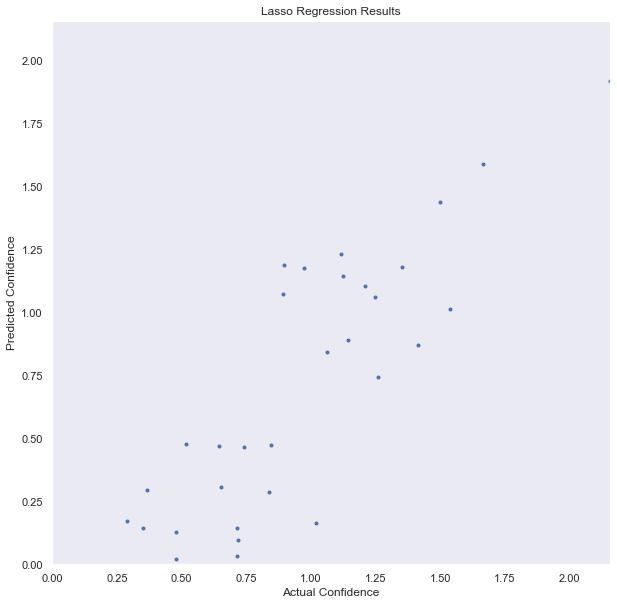

In [60]:
f = plt.figure(figsize=(10, 10))
ax = plt.axes()

ax.plot(y_volume, pipeline.predict(X_volume),
        marker='o', ls='', ms=3.0)

lim = (0, y_volume.max())

ax.set(xlabel='Actual Confidence',
       ylabel='Predicted Confidence',
       xlim=lim,
       ylim=lim,
       title='Lasso Regression Results')


Final Model Evaluation Short Recap/Conclusion:
* After building model for 3 different target, 'Volume' got the best score with the highest R2 Score


---
**2022 | Dimas Adrian Mukti / [@berodimas](https://berodimas.netlify.app/)**